# LIME

This notebook will code a self-made explainable AI-method modelled after the LIME-method: https://arxiv.org/abs/1806.08049
It uses a local surrogate model to explain how each feature influences the classifier. The original LIME suggests a linear surrogate, but because I consider binary models here, I use a logistic regression instead (which is a Generalised Linear Model GLM and therefore also "linear" in a certain sense). The LIME-method is model-agnostic, i.e. it is supposed to work on any classifier. Hence, I test it on a Neural Network and a Random Forest.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sklearn
from sklearn.linear_model import LinearRegression
from tensorflow import keras 
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
random.seed(1234)
import lime
from lime import lime_tabular
import pandas as pd

# Reproducibility
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)

/home/users/t_wand01/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/users/t_wand01/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/users/t_wand01/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/users/t_wand01/.local/lib/python3.7/site-packages/tensorflow/

In [2]:
xsize = 10000
X = np.random.rand(xsize,10)
# only X[:,0], X[:,4], X[:,1] and X[:,2] are relevant and their relevance is in that order


In [3]:
x = np.arange(0.2,0.8, 0.01)
y_boundary = -50/9 * (x-0.5)**2 + 0.5 # -0.5+2*x**2#

In [4]:
def Label(x):
    # takes x0, ... x9 and assigns label
    
    if x[1] >-50/9 * (x[0]-0.5)**2 + 0.5: # mostly 1      -0.5+2*x[0]**2.:  #
        out = np.random.choice(2,1, p=[0.1, 0.9])
    
    else: # mostly 0
        out = np.random.choice(2,1, p=[0.95, 0.05])
    return(out)

In [5]:
y_NN = np.zeros(X.shape[0])
for i in range(X.shape[0]):
    y_NN[i] = Label(X[i,:])

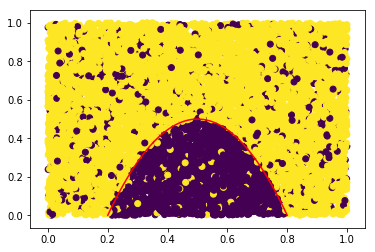

In [6]:
plt.scatter(X[:,0], X[:,1], c = y_NN)
plt.plot(x, y_boundary, c="red")
plt.show()


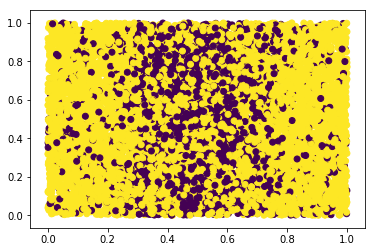

In [7]:
plt.scatter(X[:,0], X[:,2], c = y_NN)
#plt.plot(x, y_boundary, c="red")
plt.show()


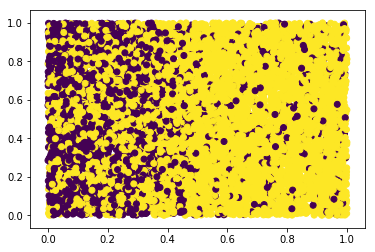

In [8]:
plt.scatter(X[:,1], X[:,3], c = y_NN)
#plt.plot(x, y_boundary, c="red")
plt.show()


In [9]:
# Get Train, Test and Validation Data
X_trainNN, X_testNN, y_trainNN, y_testNN = sklearn.model_selection.train_test_split( X, y_NN, 
                                                                                    test_size=0.66, 
                                                                                    random_state=42)

X_testNN, X_valNN, y_testNN, y_valNN = sklearn.model_selection.train_test_split( X_testNN, y_testNN, 
                                                                                    test_size=0.5, 
                                                                                    random_state=42)

In [10]:
# define the keras model
NN = keras.models.Sequential()
NN.add(keras.layers.Dense(12, input_dim=X_trainNN.shape[1], activation='relu'))
NN.add(keras.layers.Dense(50, activation='relu'))
NN.add(keras.layers.Dense(20, activation='relu'))
NN.add(keras.layers.Dense(1, activation='sigmoid'))
# compile the keras model
NN.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit the keras model on the dataset
NN.fit(X_trainNN,y_trainNN, epochs=100, batch_size=10,validation_split=0.2)
# evaluate the keras model
_, accuracy = NN.evaluate(X_testNN,y_testNN)
print('Accuracy: %.2f' % (accuracy*100))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 2720 samples, validate on 680 samples
Epoch 1/100
  10/2720 [..............................] - ETA: 17s - loss: 0.6365 - acc: 0.7000

2021-11-10 16:19:10.710126: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2021-11-10 16:19:10.733123: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 3299990000 Hz
2021-11-10 16:19:10.734382: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x5c90c00 executing computations on platform Host. Devices:
2021-11-10 16:19:10.734420: I tensorflow/compiler/xla/service/service.cc:175]   StreamExecutor device (0): <undefined>, <undefined>
2021-11-10 16:19:10.776209: W tensorflow/compiler/jit/mark_for_compilation_pass.cc:1412] (One-time warning): Not using XLA:CPU for cluster because envvar TF_XLA_FLAGS=--tf_xla_cpu_global_jit was not set.  If you want XLA:CPU, either set that envvar, or use experimental_jit_scope to enable XLA:CPU.  To confirm that XLA is active, pass --vmodule=xla_compilation_cache=1 (as a proper command-line flag, not via TF_XLA_FLAGS) or se

2720/2720 [==============================] - 0s 83us/sample - loss: 0.5474 - acc: 0.7364 - val_loss: 0.5372 - val_acc: 0.6956
Epoch 2/100
2720/2720 [==============================] - 0s 50us/sample - loss: 0.5002 - acc: 0.7507 - val_loss: 0.5046 - val_acc: 0.7368
Epoch 3/100
2720/2720 [==============================] - 0s 50us/sample - loss: 0.4921 - acc: 0.7654 - val_loss: 0.4959 - val_acc: 0.7456
Epoch 4/100
2720/2720 [==============================] - 0s 50us/sample - loss: 0.4809 - acc: 0.7713 - val_loss: 0.5211 - val_acc: 0.7309
Epoch 5/100
2720/2720 [==============================] - 0s 50us/sample - loss: 0.4664 - acc: 0.7949 - val_loss: 0.4632 - val_acc: 0.7809
Epoch 6/100
2720/2720 [==============================] - 0s 50us/sample - loss: 0.4472 - acc: 0.8143 - val_loss: 0.4399 - val_acc: 0.8059
Epoch 7/100
2720/2720 [==============================] - 0s 50us/sample - loss: 0.4226 - acc: 0.8371 - val_loss: 0.4304 - val_acc: 0.8147
Epoch 8/100
2720/2720 [=======================

2720/2720 [==============================] - 0s 51us/sample - loss: 0.2992 - acc: 0.8974 - val_loss: 0.3581 - val_acc: 0.8824
Epoch 61/100
2720/2720 [==============================] - 0s 50us/sample - loss: 0.2962 - acc: 0.9026 - val_loss: 0.3721 - val_acc: 0.8765
Epoch 62/100
2720/2720 [==============================] - 0s 50us/sample - loss: 0.2981 - acc: 0.9007 - val_loss: 0.3692 - val_acc: 0.8779
Epoch 63/100
2720/2720 [==============================] - 0s 50us/sample - loss: 0.2974 - acc: 0.8996 - val_loss: 0.3573 - val_acc: 0.8912
Epoch 64/100
2720/2720 [==============================] - 0s 50us/sample - loss: 0.2948 - acc: 0.9000 - val_loss: 0.3621 - val_acc: 0.8868
Epoch 65/100
2720/2720 [==============================] - 0s 51us/sample - loss: 0.2946 - acc: 0.9000 - val_loss: 0.3688 - val_acc: 0.8838
Epoch 66/100
2720/2720 [==============================] - 0s 50us/sample - loss: 0.2942 - acc: 0.9004 - val_loss: 0.3604 - val_acc: 0.8926
Epoch 67/100
2720/2720 [================

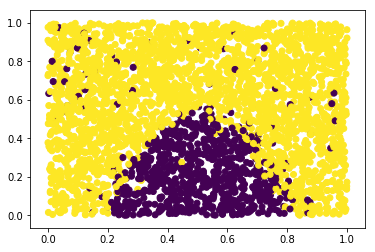

In [11]:
predNN = NN.predict(X_valNN)
predNN = (predNN > np.mean(predNN))
predNN = 1*predNN.reshape(-1)
plt.scatter(X_valNN[:,0], X_valNN[:,1], c = predNN)
plt.show()

## And with a Random Forest

In [12]:
RF = RandomForestClassifier(n_estimators=1000,random_state=4)
RF = RF.fit(X_trainNN, y_trainNN)
preds = RF.predict(X_valNN)
print(np.mean(np.abs(preds-y_valNN)))

0.11424242424242424


In [13]:
predRF = RF.predict(X_valNN)
predRF = 1*(predRF > np.mean(predRF))
predRF = predRF.reshape(-1)
print(predRF.shape)


(3300,)


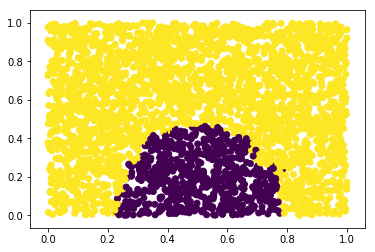

In [14]:
plt.scatter(X_valNN[:,0], X_valNN[:,1], c = predRF)
plt.show()

### LIME

In [15]:
def Dist(x, X):
    # calculate L2-distances between x and all instances in X (X does not contain x!!)
    return(((X-x)**2).sum(axis=1))

def ExpKernel(D):
    # takes an array of nonnegative distances and transforms it into a normalised probability "density"
    d = np.exp(- D**2.)
    return(d/np.sum(d))

def LocalLinear(i, K, Kernel, X, y):
    #  Local "logistic-linear" approximation of f(X[i,:]) = y[i]
    #  with K close instances (K> X.shape[1]) and y = prediction from our Model
    # could also be done via e.g. a linear regression, but log-regression makes more sense for binary models
    if K<=X.shape[1]:
        raise ValueError("K must be at least as large as X.shape[1]+1")
        
        
    x = X[i,:]
    notx = (np.arange(X.shape[0] ) !=i)
    otherX = X[notx,:]
    othery = y[notx]
    
    Distances = Dist(x,otherX) # calculate Distances between x and all other instances
    Threshold = np.partition(Distances, K)[K] # threshold for the K closest instances
    
    LRin = (Distances <=K) # now apply threshold
    LRX = otherX[LRin,:]
    LRy = othery[LRin]
    sample_weight = Kernel(Distances) # calculate the weights for linear regression
    
    
    #regr = LinearRegression()
    regr = sklearn.linear_model.LogisticRegression(random_state=3)
    regr.fit(LRX,LRy, sample_weight)
    return(regr)

##### Test on NN

In [16]:
out = 0
for i in range(X_valNN.shape[0]):
    out +=np.abs(LocalLinear(i, 20,ExpKernel, X_valNN, predNN).coef_)
    #print(LocalLinear(i, 20,ExpKernel, X_valNN, predNN).coef_)
np.set_printoptions(precision=3)
print(out)

[[ 42.425 190.149  12.355  12.74   10.365   6.349   9.892   6.781  10.816
   17.039]]


##### Test on Random Forest

In [17]:
out = 0
for i in range(X_valNN.shape[0]):
    out +=np.abs(LocalLinear(i, 20,ExpKernel, X_valNN, predRF).coef_)
    #print(LocalLinear(i, 20,ExpKernel, X_valNN, predNN).coef_)
print(out)

[[ 41.209 184.902   7.276   5.766   6.712   6.215  10.372   6.379   6.445
    7.79 ]]


In both cases, LIME correctly identifies that X[:,0] and X[:,1] are more relevant than the other features. Interestingly, it attributes a much higher importance to X[:,1]. Note that one has to look at the absolute values of the cumulative LIME-coefficients, otherwise X[:,0]-coefficients with changing signs will cancel each other out (see below).

#### Individual instances for the Neural Net with LIME
Let's look at two specific data points and see what LIME does here.

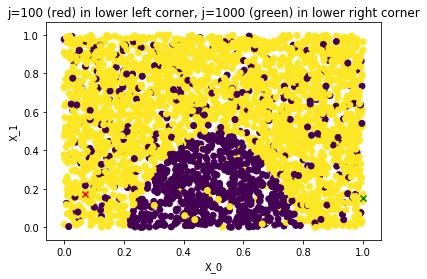

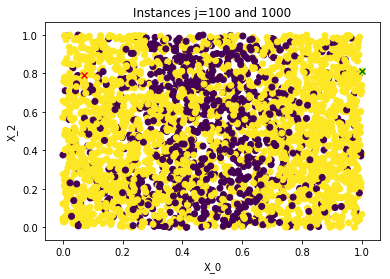

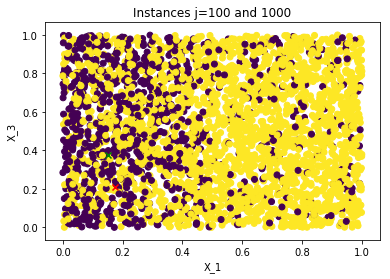

In [18]:
j = 100 
j1 = 1000 

plt.scatter(X_valNN[:,0], X_valNN[:,1], c = y_valNN)
plt.scatter(X_valNN[j,0], 
            X_valNN[j,1], 
            c = "red", 
            marker = "x")
plt.scatter(X_valNN[j1,0], 
            X_valNN[j1,1], 
            c = "green", 
            marker = "x")
plt.title("j=100 (red) in lower left corner, j=1000 (green) in lower right corner") # Lower left-hand corner
plt.xlabel("X_0")
plt.ylabel("X_1")
plt.show()

plt.scatter(X_valNN[:,0], X_valNN[:,2], c = y_valNN)
plt.scatter(X_valNN[j,0], 
            X_valNN[j,2], 
            c = "red", 
            marker = "x")
plt.scatter(X_valNN[j1,0], 
            X_valNN[j1,2], 
            c = "green", 
            marker = "x")
plt.title("Instances j=100 and 1000")
plt.xlabel("X_0")
plt.ylabel("X_2")
plt.show()

plt.scatter(X_valNN[:,1], X_valNN[:,3], c = y_valNN)
plt.scatter(X_valNN[j,1], 
            X_valNN[j,3], 
            c = "red", 
            marker = "x")
plt.scatter(X_valNN[j1,1], 
            X_valNN[j1,3], 
            c = "green", 
            marker = "x")
plt.title("Instances j=100 and 1000")
plt.xlabel("X_1")
plt.ylabel("X_3")
plt.show()

In [19]:
# Look at the local logistic-linear coefficients
print(LocalLinear(j, 20,ExpKernel, X_valNN, predNN).coef_)
print(LocalLinear(j1, 20,ExpKernel, X_valNN, predNN).coef_)


[[-0.028  0.062 -0.001 -0.007 -0.003 -0.003  0.001 -0.004  0.002 -0.007]]
[[ 0.035  0.059 -0.002 -0.006 -0.002 -0.002 -0.004 -0.005 -0.003 -0.006]]


We can see that the two instances have different logistic-linear coefficients: The 8 superfluous coefficients are all close to 0 (which is good). The coefficient for x_1 is positive in both cases because wherever in the feature space you are, a higher x_1 will always push you away from the purple region of Zeros. However, the coefficients' signs for x_0 change: In the x_0-x_1-plot, the instance j=100 is to the left of the purple region and hence, its x_0-coefficient is negative (the further left, the further it gets away from the Zeros). For j=1000, it's the complete opposite (positive sign) because its to the right of the purple region.
Therefore, to measure the cumulative impact of the LIME-x_0-feature across all instances, one has to look at the absolute values. Else, just summing the coefficients would cancel them out due to changing signs.

## Now we try to use the package LIME

Tutorial on YouTube https://www.youtube.com/watch?v=eUu9xwraeqo
Documentation https://lime-ml.readthedocs.io/en/latest/lime.html#module-lime.lime_tabular

In [20]:
# I think we need some pandas dataframes here, unfortunately
dfTrain = pd.DataFrame(data = X_trainNN)
dfTest = pd.DataFrame(data=X_testNN)
dfVal = pd.DataFrame(data=X_valNN)
print(dfTrain.columns)

RangeIndex(start=0, stop=10, step=1)


In [21]:
X_valNN[100,:]

array([0.071, 0.173, 0.792, 0.211, 0.546, 0.057, 0.873, 0.441, 0.755,
       0.211])

In [22]:
print(NN.predict_proba(X_valNN[100,:].reshape(1,-1)))
print(NN.predict_proba(X_valNN[101,:].reshape(1,-1)))

[[0.892]]
[[0.726]]


In [23]:

explainer = lime_tabular.LimeTabularExplainer(training_data = np.array(dfVal),# data in LimeTabularExplainer has to be numpy array
                                              mode =  "classification", # "regression" would also be possible
                                              feature_names = dfVal.columns,
                                             class_names=[0,1],
                                             discretize_continuous=False, # we want to keep the continuous features
                                             random_state= 4321)

We will take a closer look at the following three instances:

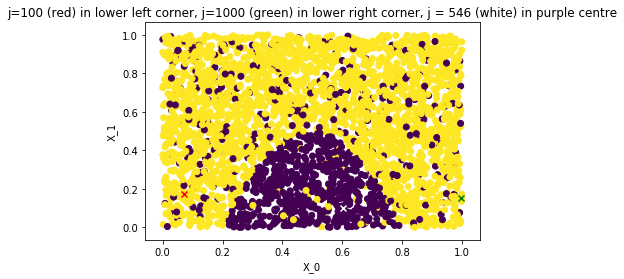

In [24]:
j = 100 
j1 = 1000 
j2 = 546
j3 = 19

plt.scatter(X_valNN[:,0], X_valNN[:,1], c = y_valNN)
plt.scatter(X_valNN[j,0], 
            X_valNN[j,1], 
            c = "red", 
            marker = "x")
plt.scatter(X_valNN[j1,0], 
            X_valNN[j1,1], 
            c = "green", 
            marker = "x")
plt.scatter(X_valNN[j2,0], 
            X_valNN[j2,1], 
            c = "white", 
            marker = "x")
plt.title("j=100 (red) in lower left corner, j=1000 (green) in lower right corner, j = 546 (white) in purple centre" ) # Lower left-hand corner
plt.xlabel("X_0")
plt.ylabel("X_1")
plt.show()

In [25]:
# evaluate one instance
j = 100
exp = explainer.explain_instance(data_row = X_valNN[j,:],#data_row= np.array(dfTest.iloc[j]).reshape(1,-1),
                                labels=(0,), # cf   https://github.com/marcotcr/lime/issues/428
                                predict_fn = NN.predict_proba)
exp.show_in_notebook(show_table=True)

/home/users/t_wand01/.local/lib/python3.7/site-packages/lime/lime_tabular.py:377: UserWarning: 
                    Prediction probabilties do not sum to 1, and
                    thus does not constitute a probability space.
                    Check that you classifier outputs probabilities
                    (Not log probabilities, or actual class predictions).
                    
  """)


#### What does LIME tell us here?
On the left-hand side, there is the probability of the 100th instance being classified as a One, which is very close to 100%.
In the centre, all feature values of the 100th instance are being judged whether they moved the prediction closer to a Zero or to a One. Only x_1 has a reasonably high contribution compared to the other instances and its value (when evaluated on the local linear neighbourhood) moves the prediction closer to One, as indicated by the yellow bar. x_0 has the next highest contribution (albeit against One), but its effect is rather low compared to x_1.

In [26]:
j = 1000
exp = explainer.explain_instance(data_row = X_valNN[j,:],#data_row= np.array(dfTest.iloc[j]).reshape(1,-1),
                                labels=(0,), # cf   https://github.com/marcotcr/lime/issues/428
                                predict_fn = NN.predict_proba)
exp.show_in_notebook(show_table=True)

/home/users/t_wand01/.local/lib/python3.7/site-packages/lime/lime_tabular.py:377: UserWarning: 
                    Prediction probabilties do not sum to 1, and
                    thus does not constitute a probability space.
                    Check that you classifier outputs probabilities
                    (Not log probabilities, or actual class predictions).
                    
  """)


Again, the probability of the 1000th instance being classified as a One is very close to 100%.
Again, x_1 has a huge contribution to this classification. But for this instance, the x_0 feature also has a small contribution in favour of "One". This probably reflects our observations for the self-made LIME-programme with respect to whether the instance is to the left or right of the purple cone (cf. block [19]).


In [27]:
j = 546
exp = explainer.explain_instance(data_row = X_valNN[j,:],#data_row= np.array(dfTest.iloc[j]).reshape(1,-1),
                                labels=(0,), # cf   https://github.com/marcotcr/lime/issues/428
                                predict_fn = NN.predict_proba)
exp.show_in_notebook(show_table=True)

/home/users/t_wand01/.local/lib/python3.7/site-packages/lime/lime_tabular.py:377: UserWarning: 
                    Prediction probabilties do not sum to 1, and
                    thus does not constitute a probability space.
                    Check that you classifier outputs probabilities
                    (Not log probabilities, or actual class predictions).
                    
  """)


This instance is in the middle of the purple cone (white cross). According to the Local LIME explainer, changes along the x0 axis have basically no effect (0.01) for this instance's prediction, whereas changes in x1 still do.